In [1]:
import pandas as pd

**1. Самостоятельно повторить tfidf** (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

In [2]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


#### Получаем векторные представления новостей

In [4]:
#предобработка текстов
import re
import numpy as np
from gensim.corpora.dictionary import Dictionary
import nltk
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize
from razdel import tokenize 
import pymorphy2  

In [5]:
nltk.download('stopwords')
stopword_ru = stopwords.words('russian')
print(len(stopword_ru))

151


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
    
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [7]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub('n', ' ', text)
    
    return text

cache = {}
morph = pymorphy2.MorphAnalyzer()

def lemmatization(text):    
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист лемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w) > 1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords = [i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [8]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

C:\Users\User\AppData\Local\Temp/ipykernel_17288/1880867539.py:14: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 20.1 s


In [9]:
news['title'].iloc[:10]

0    заместитель председателя правительства рф серг...
1    матч  финала кубка россии по футболу был приос...
2    форвард авангарда томаш заборский прокомментир...
3    главный тренер кубани юрий красножан прокоммен...
4    решением попечительского совета владивостокско...
5    ио главного тренера вячеслав буцаев прокоммент...
6    запорожский металлург дома потерпел разгромное...
7    сборная сша одержала победу над австрией со сч...
8    бывший защитник сборной россии дарюс каспарайт...
9    полузащитник цска зоран тошич после победы над...
Name: title, dtype: object

In [10]:
%%time
#Запускаем лемматизацию текстcа. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 2min 37s


In [11]:
news['title'].iloc[:2].apply(lambda x: lemmatization(x))

0    [заместитель, председатель, правительство, рф,...
1    [матч, финал, кубок, россия, футбол, приостано...
Name: title, dtype: object

А теперь в 3 строчки обучим нашу модель

In [12]:
# сформируем список наших текстов
texts = list(news['title'].values)

# Создадим корпус из списка с текстами
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [13]:
common_dictionary[4]

'банк'

In [14]:
len(common_dictionary)

135723

In [15]:
# common_dictionary.id2token

In [16]:
common_dictionary.doc2bow(['коллега', 'пошел', 'пить', 'чай'], allow_update=True)

[(1036, 1), (6204, 1), (12347, 1), (135723, 1)]

Запускаем обучение

In [17]:
from gensim.models import LdaModel
# Обучаем модель на корпусе
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

In [18]:
from gensim.test.utils import datapath

# Сохраняем модель на диск
temp_file = datapath("model.lda")
lda.save(temp_file)

# Загружаем обученную модель с диска
lda = LdaModel.load(temp_file)

In [19]:
# Создаем новый корпус документов
other_texts = list(news['title'].iloc[:3])
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(0, 0.19049923),
 (2, 0.08676188),
 (11, 0.029688174),
 (15, 0.100160785),
 (23, 0.574589)]

In [20]:
x = lda.show_topics(num_topics=25, num_words=7, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

# Печатаем только слова
for topic, words in topics_words:
    print(f"topic_{topic}: " + " ".join(words))

topic_0: суд земля год восток это который иск
topic_1: это который год мочь человек весь россия
topic_2: который человек это год дело также свой
topic_3: грунт reuters египетский предсказать грузовик колесо взорваться
topic_4: университет армения опрос кандидат азербайджан казахстан тест
topic_5: статья который суд писать это убийство время
topic_6: сша территория страна компания пострадать который россия
topic_7: ракета военный который экипаж год район км
topic_8: газ температура рак космос день двигатель земля
topic_9: год млн рубль банк млрд цена ребёнок
topic_10: научный форум медведев билет остаток лесной технология
topic_11: турецкий турция рейс кость предмет визовый паника
topic_12: тело миссия девочка виза еда жертва пляж
topic_13: который санкция это фонд мочь научный компания
topic_14: взрыв это источник президент риск государство глава
topic_15: городской австралия австралийский польский польша округ передовой
topic_16: станция мозг проверка болезнь километр карта объект
top

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [21]:
def get_lda_vector(lda, text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]

    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [22]:
get_lda_vector(lda, news['title'].iloc[0])

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.08563515, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.63953316,
       0.        , 0.        , 0.        , 0.        , 0.25541636,
       0.        , 0.01137794, 0.        , 0.        , 0.        ])

In [23]:
%%time
topic_matrix = pd.DataFrame([get_lda_vector(lda, text) for text in news['title'].values])
topic_matrix.columns = [f'topic_{i}' for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+[f'topic_{i}' for i in range(25)]]
topic_matrix.head(5)

Wall time: 29.3 s


,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.000000,0.000000,0.0,0.0,0.085626,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.255371,0.0,0.011378,0.0,0.000000,0.0
1,4896,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.201048,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.059997,0.0
2,4897,0.190561,0.000000,0.086738,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.100172,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.574544,0.0
3,4898,0.000000,0.317019,0.367988,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.041880,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.262797,0.0
4,4899,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.551841,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0


Мы получили вектора наших новостей и умеем интерпретировать получившиеся темы

#### Следующий шаг - векторные представления пользователей

In [24]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [25]:
# из матрицы в словарь новостей
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[[f'topic_{i}' for i in range(25)]].values))

In [26]:
# вектор тематик новостей
doc_dict[293622]

array([0.        , 0.11960185, 0.17200033, 0.        , 0.        ,
       0.        , 0.        , 0.02468447, 0.        , 0.        ,
       0.        , 0.01744896, 0.        , 0.14223485, 0.10086764,
       0.        , 0.        , 0.2541213 , 0.04067853, 0.03622395,
       0.        , 0.        , 0.        , 0.08329049, 0.        ])

In [27]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [28]:
get_user_embedding(user_articles_list)

array([0.0187612 , 0.17599951, 0.17768088, 0.        , 0.00623303,
       0.03482224, 0.05155357, 0.04125687, 0.01539309, 0.04748367,
       0.        , 0.        , 0.        , 0.13217699, 0.03815105,
       0.        , 0.00455775, 0.        , 0.00399913, 0.0392362 ,
       0.        , 0.01850187, 0.        , 0.        , 0.18122878])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [29]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.010136,0.141216,0.062507,0.010207,0.000000,0.004318,0.013228,0.012251,0.000000,...,0.0,0.013844,0.054184,0.022344,0.118730,0.0,0.006247,0.037451,0.017954,0.256961
1,u108690,0.037089,0.220370,0.179725,0.010846,0.001879,0.054149,0.071201,0.016062,0.000000,...,0.0,0.006487,0.011337,0.016495,0.037076,0.0,0.005176,0.003774,0.012312,0.157333
2,u108339,0.014920,0.110993,0.251075,0.000000,0.000000,0.074624,0.089596,0.021585,0.048213,...,0.0,0.014583,0.012417,0.008324,0.045221,0.0,0.001699,0.000000,0.004748,0.165663


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [30]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [31]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.010136,0.141216,0.062507,0.010207,0.000000,0.004318,0.013228,0.012251,0.000000,...,0.013844,0.054184,0.022344,0.118730,0.0,0.006247,0.037451,0.017954,0.256961,0
1,u108690,0.037089,0.220370,0.179725,0.010846,0.001879,0.054149,0.071201,0.016062,0.000000,...,0.006487,0.011337,0.016495,0.037076,0.0,0.005176,0.003774,0.012312,0.157333,1
2,u108339,0.014920,0.110993,0.251075,0.000000,0.000000,0.074624,0.089596,0.021585,0.048213,...,0.014583,0.012417,0.008324,0.045221,0.0,0.001699,0.000000,0.004748,0.165663,1


In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [33]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(25)]], X['churn'], random_state=0)

In [34]:
logreg = LogisticRegression()
# обучим наш пайплайн
logreg.fit(X_train, y_train)

LogisticRegression()

In [35]:
# наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.16799073, 0.02701111, 0.49625605, 0.21672489, 0.0105105 ,
       0.02948623, 0.17018111, 0.00416935, 0.12004807, 0.08405507])

#### Рассчитаем Precision, Recall, F_score

In [36]:
metrics_df = pd.DataFrame(columns=['model', 'F-Score', 'Precision', 'Recall', 'ROC AUC'])

In [37]:
from sklearn.metrics import (f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix)

In [38]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.309636, F-Score=0.718, Precision=0.685, Recall=0.755


In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1670   85]
 [  61  184]]


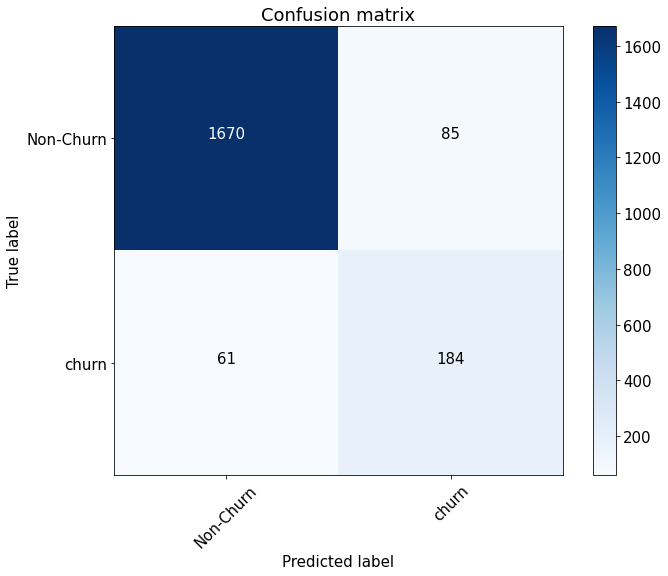

In [40]:
import itertools
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [41]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9596883539740683

In [42]:
metrics_df = metrics_df.append({
    'model': np.mean.__name__,
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc
}, ignore_index=True)

**2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог)**

In [43]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [44]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.162827,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.017265,0.0,0.018112,0.0,0.0,0.0,0.0,0.209895
1,u108690,0.017192,0.217634,0.155432,0.0,0.0,0.039999,0.077001,0.009607,0.000000,...,0.0,0.000000,0.000000,0.0,0.005036,0.0,0.0,0.0,0.0,0.128842
2,u108339,0.000000,0.111241,0.214166,0.0,0.0,0.082124,0.078673,0.010918,0.030611,...,0.0,0.008636,0.000000,0.0,0.039010,0.0,0.0,0.0,0.0,0.157318


In [45]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.162827,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.017265,0.0,0.018112,0.0,0.0,0.0,0.0,0.209895,0
1,u108690,0.017192,0.217634,0.155432,0.0,0.0,0.039999,0.077001,0.009607,0.000000,...,0.000000,0.000000,0.0,0.005036,0.0,0.0,0.0,0.0,0.128842,1
2,u108339,0.000000,0.111241,0.214166,0.0,0.0,0.082124,0.078673,0.010918,0.030611,...,0.008636,0.000000,0.0,0.039010,0.0,0.0,0.0,0.0,0.157318,1


In [46]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [47]:
model = LogisticRegression()
# обучим 
model.fit(X_train, y_train)

LogisticRegression()

In [48]:
# наши прогнозы для тестовой выборки
preds = model.predict_proba(X_test)[:, 1]
preds[:10]

array([0.23733835, 0.01899403, 0.42606457, 0.18682366, 0.00603731,
       0.00469747, 0.21278142, 0.00203639, 0.10584906, 0.14955111])

In [49]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.31573315050826933, F-Score=0.731, Precision=0.678, Recall=0.792


Confusion matrix, without normalization
[[1663   92]
 [  52  193]]


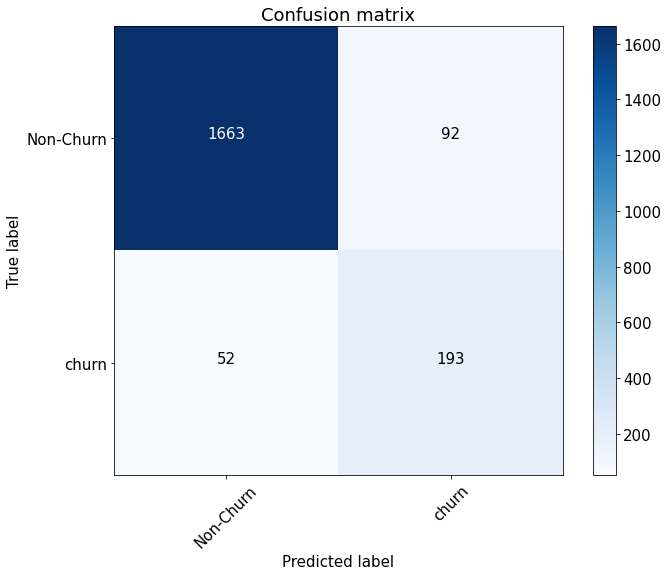

In [50]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [51]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9620791906506192

In [52]:
metrics_df = metrics_df.append({
    'model': np.median.__name__,
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc
}, ignore_index=True)

**3. Повторить п.2, но используя уже не медиану, а max**

In [53]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [54]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.060814,0.294111,0.203041,0.044753,0.000000,0.025910,0.079368,0.048822,0.000000,...,0.0,0.083063,0.254121,0.093388,0.563821,0.0,0.037482,0.136464,0.083290,0.593435
1,u108690,0.159756,0.393235,0.502349,0.065074,0.011275,0.187101,0.151409,0.050811,0.000000,...,0.0,0.024080,0.035305,0.087336,0.183762,0.0,0.031056,0.022643,0.055633,0.359789
2,u108339,0.062103,0.192098,0.479793,0.000000,0.000000,0.160260,0.174293,0.055878,0.145046,...,0.0,0.040741,0.063913,0.028061,0.096844,0.0,0.010193,0.000000,0.015177,0.321067


In [55]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.060814,0.294111,0.203041,0.044753,0.000000,0.025910,0.079368,0.048822,0.000000,...,0.083063,0.254121,0.093388,0.563821,0.0,0.037482,0.136464,0.083290,0.593435,0
1,u108690,0.159756,0.393235,0.502349,0.065074,0.011275,0.187101,0.151409,0.050811,0.000000,...,0.024080,0.035305,0.087336,0.183762,0.0,0.031056,0.022643,0.055633,0.359789,1
2,u108339,0.062103,0.192098,0.479793,0.000000,0.000000,0.160260,0.174293,0.055878,0.145046,...,0.040741,0.063913,0.028061,0.096844,0.0,0.010193,0.000000,0.015177,0.321067,1


In [56]:
# # разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [57]:
model = LogisticRegression()
# обучим 
model.fit(X_train, y_train)

LogisticRegression()

In [58]:
# # наши прогнозы для тестовой выборки
preds = model.predict_proba(X_test)[:, 1]
preds[:10]

array([0.11863827, 0.00591467, 0.9404214 , 0.06713245, 0.04151176,
       0.00781168, 0.10711871, 0.00778001, 0.04087394, 0.02549167])

In [59]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.32752984689148124, F-Score=0.805, Precision=0.786, Recall=0.824


Confusion matrix, without normalization
[[1700   55]
 [  44  201]]


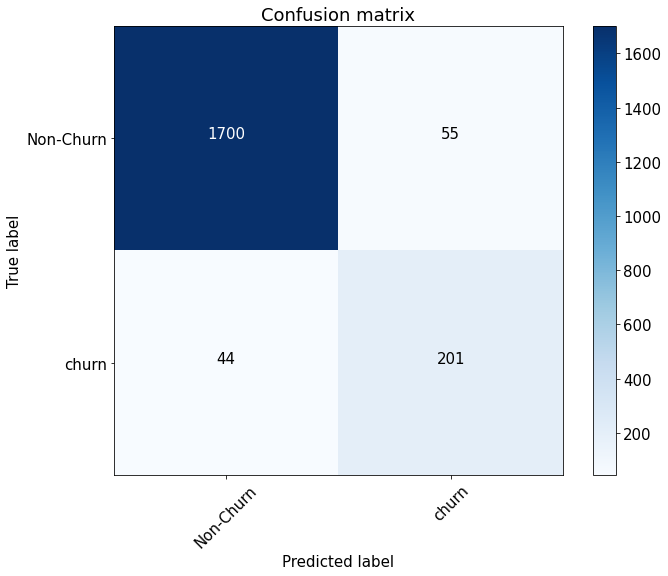

In [60]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [61]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9780475609047037

**5. Сформировать на выходе единую таблицу, сравнивающую качество 2/3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score**

In [62]:
metrics_df = metrics_df.append({
    'model': np.max.__name__,
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc
}, ignore_index=True)

metrics_df

,model,F-Score,Precision,Recall,ROC AUC
0,mean,0.718447,0.685185,0.755102,0.959688
1,median,0.730697,0.678322,0.791837,0.962079
2,amax,0.804781,0.785992,0.824490,0.978048


**6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных**

Способ max в качестве метода получения эмбендингов является наиболее сбалансированным по параметрам precision, recall, f_score, а также дает максимальный roc_auc